<a href="https://www.kaggle.com/code/echometerhhwl/who-s-that-pokemon-improved?scriptVersionId=139122993" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
from fastcore.all import *
from fastai.vision.all import *
import os
import PIL
from PIL import ImageFile
from ipywidgets import FileUpload
import io
import pandas as pd
import random
from IPython.display import display, Image

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Use pretrained model (optional)

In [2]:
if not os.path.exists("./model.pkl"):
    !wget https://github.com/echometerain/whos-that-pokemon/raw/main/model.pkl
learn = load_learner('./model.pkl')

--2023-08-07 00:01:01--  https://github.com/echometerain/whos-that-pokemon/raw/main/model.pkl
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/echometerain/whos-that-pokemon/main/model.pkl [following]
--2023-08-07 00:01:01--  https://media.githubusercontent.com/media/echometerain/whos-that-pokemon/main/model.pkl
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 115679821 (110M) [application/octet-stream]
Saving to: ‘model.pkl’

model.pkl           100%[===================>] 110.32M   258MB/s    in 0.4s    

2023-08-07 00:01:05 (258 MB/s) - ‘model.pkl’ saved [115679821/115679821]

## Train
Skip if using a paretrained model

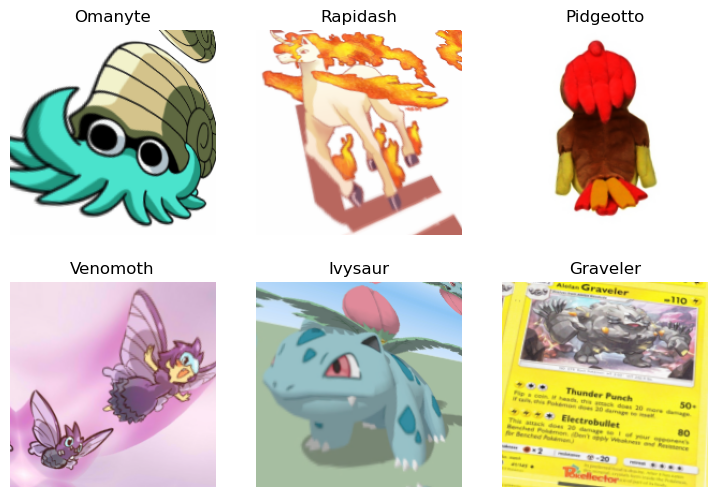

In [3]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')],
    batch_tfms=aug_transforms(mult=2)
).dataloaders(Path("/kaggle/input/pokemon-gen-1-38914/data"), bs=64, num_workers=8)
dls.show_batch(max_n=6)

In [4]:
if not os.path.exists("./model.pkl"):
    learn = vision_learner(dls, "convnext_tiny.fb_in22k_ft_in1k", metrics=error_rate)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        ImageFile.LOAD_TRUNCATED_IMAGES = True
        learn.fine_tune(12)

In [5]:
if not os.path.exists("./model.pkl"):
    learn.export('model.pkl')

## Predict
(only predicts top of upload stack)

In [6]:
upload = FileUpload()
upload

FileUpload(value={}, description='Upload')

### Test file

In [7]:
!wget -O test.png https://upload.wikimedia.org/wikipedia/en/a/a6/Pok%C3%A9mon_Pikachu_art.png
upload.data = [open("./test.png", "rb").read()]

--2023-08-07 00:01:27--  https://upload.wikimedia.org/wikipedia/en/a/a6/Pok%C3%A9mon_Pikachu_art.png
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53612 (52K) [image/png]
Saving to: ‘test.png’

test.png            100%[===================>]  52.36K  --.-KB/s    in 0.03s   

2023-08-07 00:01:27 (1.94 MB/s) - ‘test.png’ saved [53612/53612]



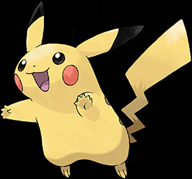

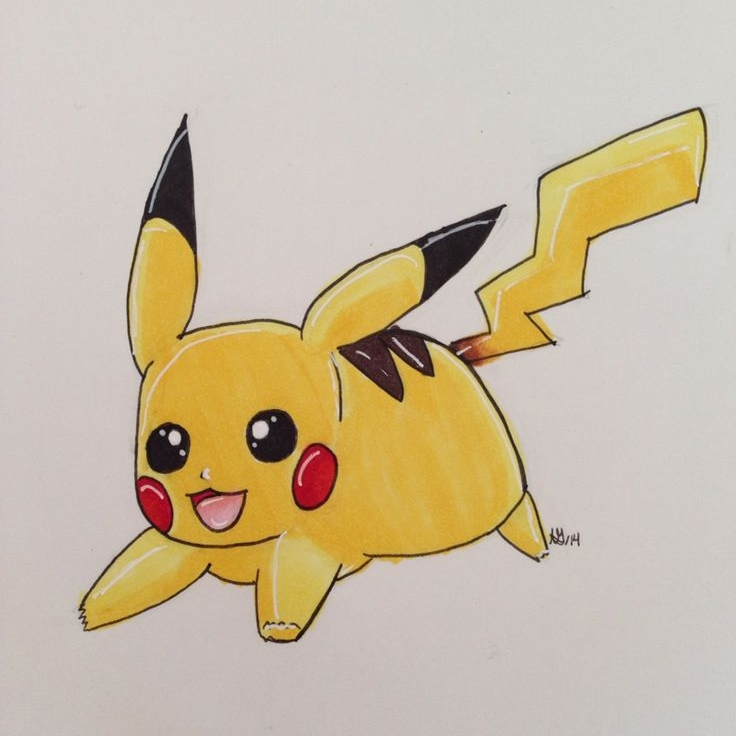

This is a: Pikachu. Probability: 99.9996%

                    %
Pikachu     99.999641
Raichu       0.000207
Diglett      0.000066
Psyduck      0.000035
Weepinbell   0.000013


In [8]:
if upload.data != []:
    img = PILImage.create(io.BytesIO(upload.data[0]))
    img.thumbnail((192, 192))
    item,_,probs = learn.predict(img)
    display(img)
    rand_img = random.choice(os.listdir(f"/kaggle/input/pokemon-gen-1-38914/data/{item}"))
    display(Image(filename=f"/kaggle/input/pokemon-gen-1-38914/data/{item}/{rand_img}", width=120))

    df = pd.DataFrame(data=probs.numpy()*100, index=learn.dls.vocab, columns=["%"])
    df.sort_values(inplace=True, by="%", ascending=False)
    print(f"This is a: {item}. Probability: {df.loc[item, '%']:.4f}%")
    print()
    print(df.head())

## Fix dataset

In [9]:
# !mkdir ./data
# !rsync -auvzq "/kaggle/input/pokemon-gen-1-38914/data"/* ./data
# dls = DataBlock(
#     blocks=(ImageBlock, CategoryBlock), 
#     get_items=get_image_files, 
#     splitter=RandomSplitter(valid_pct=0.2, seed=42),
#     get_y=parent_label,
#     item_tfms=[Resize(192, method='squish')],
#     batch_tfms=aug_transforms(mult=2)
# ).dataloaders(Path("./data"), bs=64, num_workers=8)

In [10]:
# !tar czf archive.tar.gz ./data

In [11]:
# from IPython.display import FileLink
# FileLink(r'archive.tar.gz')